# Tutorial:Batch dataset

In this tutorial, we will show how to use scMAGCA for batch correction. As an example, we use a mouse Glioblastoma (GBM) dataset 'GSE163120' containing 24559 cells. Specifically, the dataset contains two omicsc and two batches, with ADT containing 174 features and RNA containing 12411 features.

## Loading package

In [1]:
import numpy as np
import pandas as pd
import torch
import scanpy as sc
import random
import warnings
from scipy.sparse import csr_matrix
from scipy.io import mmread
from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings("ignore")

/home/zhouzeming/anaconda3/lib/python3.9/site-packages/setuptools_scm/_integration/setuptools.py:30: RuntimeWarning: 
ERROR: setuptools==58.0.4 is used in combination with setuptools_scm>=8.x

Your build configuration is incomplete and previously worked by accident!
setuptools_scm requires setuptools>=61

Suggested workaround if applicable:
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build dependencies
   which are reliably pre-installed before running the build tools

  warnings.warn(
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from scMAGCA.preprocess import read_dataset, preprocess_dataset
from scMAGCA.utils import *
from scMAGCA.scMAGCA_batch import scMultiCluster

In [3]:
# set seed
random.seed(3407)
np.random.seed(3407)
torch.manual_seed(3407)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False

## Reading dataset

We fully took into account the batch information of the batch dataset when correcting for batch effects.

The required input files include: 
1) x1: protein abundance matrix (data format is csv file) : ADT.csv; \
2) x2: Gene expression matrix (data format is mtx file) : matrix.mtx; \
3) Real label ('cell_label' column in csv file) : GSE163120_label.csv; \
4) Batch information ('batch_id' column in csv file) : GSE163120_label.csv.

To ensure reproducibility of the results, please read the above data as follows:

In [4]:
x1 = np.array(pd.read_csv('../datasets/GSE163120/ADT.csv',index_col=0).T)
x2 = csr_matrix(mmread('../datasets/GSE163120/matrix.mtx').T).toarray()
y = np.array(pd.read_csv('../datasets/GSE163120/GSE163120_label.csv', index_col=0)['cell_label'])
b = np.array(pd.read_csv('../datasets/GSE163120/GSE163120_label.csv', index_col=0)['batch_id'])
enc = OneHotEncoder()
enc.fit(b.reshape(-1, 1))
B = enc.transform(b.reshape(-1, 1)).toarray()

In [5]:
x1,x2,y,b

(array([[ 0,  0,  0, ...,  0,  0,  0],
        [24,  0,  0, ...,  0,  0,  0],
        [19,  8,  0, ...,  0,  0,  0],
        ...,
        [ 4,  0,  3, ...,  3,  0,  0],
        [ 2,  1,  0, ...,  2,  0,  0],
        [ 8,  1,  0, ...,  2,  0,  0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [2, 2, 7, ..., 3, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 4, 1, 0],
        [0, 1, 0, ..., 0, 1, 0],
        [3, 0, 4, ..., 2, 0, 0]]),
 array([ 5, 11, 17, ...,  1,  3,  0]),
 array([0, 0, 0, ..., 1, 1, 1]))

Due to the small number of features in ADT omics data and the large gap between the feature dimensions of RNA omics, for RNA+ADT data, we only select high-expression features for RNA omics (the default number of chosen genes is 2000).

Chosen offset: 0.29


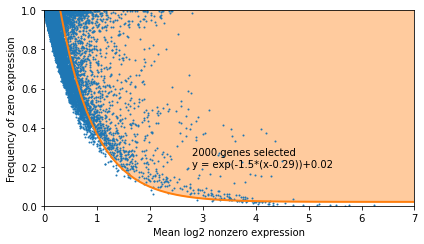

In [6]:
importantGenes = geneSelection(x2, n=2000)
x2 = x2[:, importantGenes]

In [7]:
adata1 = sc.AnnData(x1)
adata1 = read_dataset(adata1, copy=True)
adata1 = preprocess_dataset(adata1, normalize_input=True, logtrans_input=True)

### Autoencoder: Successfully preprocessed 174 features and 24559 cells.


In [8]:
adata1

AnnData object with n_obs × n_vars = 24559 × 174
    obs: 'DCA_split', 'size_factors'
    var: 'mean', 'std'
    uns: 'log1p'

In [9]:
adata2 = sc.AnnData(x2)
adata2 = read_dataset(adata2, copy=True)
adata2 = preprocess_dataset(adata2, normalize_input=True, logtrans_input=True)

### Autoencoder: Successfully preprocessed 2000 features and 24559 cells.


In [10]:
adata2

AnnData object with n_obs × n_vars = 24559 × 2000
    obs: 'DCA_split', 'size_factors'
    var: 'mean', 'std'
    uns: 'log1p'

## Training the model

In [11]:
model = scMultiCluster(input_dim1=adata1.n_vars, input_dim2=adata2.n_vars, n_batch=2,
                       alpha=0.2,beta=0.8,gama=0.01,device='cuda').to('cuda')

Note: When correcting datasets with batch effects, the actual number of batches need to be provided.

In [12]:
model

scMultiCluster(
  (encoder): Encoder(
    (stacked_gnn): ModuleList(
      (0): GCNConv(2176, 1024)
      (1): GCNConv(1024, 256)
      (2): GCNConv(256, 64)
      (3): GCNConv(64, 8)
    )
    (stacked_bns): ModuleList(
      (0): BatchNorm1d(1024, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (3): BatchNorm1d(8, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    )
    (stacked_prelus): ModuleList(
      (0-3): 4 x PReLU(num_parameters=1)
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Linear(in_features=512, out_features=1024, bias=True)
    (4): BatchNorm1d(1024, eps=1e-05, momentum

In [13]:
pretrain_latent = model.pretrain_autoencoder(
                        X1=adata1.X, X2=adata2.X, X1_raw=adata1.raw.X, X2_raw=adata2.raw.X, 
                        B=B, epochs=400, file='GSE163120')

Pretraining stage
Pretrain epoch 1, recon_loss:1.174770, zinb_loss:2.021940, adversial_loss:1.448147
Pretrain epoch 2, recon_loss:1.151908, zinb_loss:1.944988, adversial_loss:1.447797
Pretrain epoch 3, recon_loss:0.941301, zinb_loss:1.855513, adversial_loss:1.440014
Pretrain epoch 4, recon_loss:0.850893, zinb_loss:1.770818, adversial_loss:1.436623
Pretrain epoch 5, recon_loss:0.814821, zinb_loss:1.691993, adversial_loss:1.434692
Pretrain epoch 6, recon_loss:0.807255, zinb_loss:1.620129, adversial_loss:1.431878
Pretrain epoch 7, recon_loss:0.797138, zinb_loss:1.555519, adversial_loss:1.428869
Pretrain epoch 8, recon_loss:0.784488, zinb_loss:1.499163, adversial_loss:1.427543
Pretrain epoch 9, recon_loss:0.773013, zinb_loss:1.449482, adversial_loss:1.426432
Pretrain epoch 10, recon_loss:0.764595, zinb_loss:1.405877, adversial_loss:1.425571
Pretrain epoch 11, recon_loss:0.757382, zinb_loss:1.367658, adversial_loss:1.425086
Pretrain epoch 12, recon_loss:0.750995, zinb_loss:1.334295, adversi

Pretrain epoch 99, recon_loss:0.627247, zinb_loss:0.980134, adversial_loss:1.429293
Pretrain epoch 100, recon_loss:0.626712, zinb_loss:0.979490, adversial_loss:1.429212
Pretrain epoch 101, recon_loss:0.626367, zinb_loss:0.978948, adversial_loss:1.429038
Pretrain epoch 102, recon_loss:0.625858, zinb_loss:0.978325, adversial_loss:1.429015
Pretrain epoch 103, recon_loss:0.625516, zinb_loss:0.977792, adversial_loss:1.429042
Pretrain epoch 104, recon_loss:0.625104, zinb_loss:0.977240, adversial_loss:1.429012
Pretrain epoch 105, recon_loss:0.624742, zinb_loss:0.976691, adversial_loss:1.428981
Pretrain epoch 106, recon_loss:0.624316, zinb_loss:0.976169, adversial_loss:1.429068
Pretrain epoch 107, recon_loss:0.623914, zinb_loss:0.975606, adversial_loss:1.428961
Pretrain epoch 108, recon_loss:0.623572, zinb_loss:0.975113, adversial_loss:1.428916
Pretrain epoch 109, recon_loss:0.623133, zinb_loss:0.974610, adversial_loss:1.429048
Pretrain epoch 110, recon_loss:0.622807, zinb_loss:0.974098, adver

Pretrain epoch 197, recon_loss:0.603229, zinb_loss:0.953886, adversial_loss:1.427807
Pretrain epoch 198, recon_loss:0.603240, zinb_loss:0.955095, adversial_loss:1.427271
Pretrain epoch 199, recon_loss:0.602859, zinb_loss:0.955135, adversial_loss:1.427088
Pretrain epoch 200, recon_loss:0.601353, zinb_loss:0.952706, adversial_loss:1.428152
Pretrain epoch 201, recon_loss:0.601788, zinb_loss:0.952935, adversial_loss:1.427828
Pretrain epoch 202, recon_loss:0.602279, zinb_loss:0.953297, adversial_loss:1.427325
Pretrain epoch 203, recon_loss:0.600736, zinb_loss:0.951970, adversial_loss:1.427600
Pretrain epoch 204, recon_loss:0.601353, zinb_loss:0.952870, adversial_loss:1.427555
Pretrain epoch 205, recon_loss:0.600841, zinb_loss:0.951904, adversial_loss:1.427374
Pretrain epoch 206, recon_loss:0.600565, zinb_loss:0.952214, adversial_loss:1.427428
Pretrain epoch 207, recon_loss:0.600366, zinb_loss:0.951833, adversial_loss:1.427639
Pretrain epoch 208, recon_loss:0.600176, zinb_loss:0.951553, adve

Pretrain epoch 295, recon_loss:0.588595, zinb_loss:0.944889, adversial_loss:1.423803
Pretrain epoch 296, recon_loss:0.588636, zinb_loss:0.944955, adversial_loss:1.423836
Pretrain epoch 297, recon_loss:0.588296, zinb_loss:0.944849, adversial_loss:1.423315
Pretrain epoch 298, recon_loss:0.588316, zinb_loss:0.944757, adversial_loss:1.423798
Pretrain epoch 299, recon_loss:0.587997, zinb_loss:0.944757, adversial_loss:1.423531
Pretrain epoch 300, recon_loss:0.587803, zinb_loss:0.944592, adversial_loss:1.423436
Pretrain epoch 301, recon_loss:0.587743, zinb_loss:0.944545, adversial_loss:1.423621
Pretrain epoch 302, recon_loss:0.587472, zinb_loss:0.944469, adversial_loss:1.423401
Pretrain epoch 303, recon_loss:0.587392, zinb_loss:0.944377, adversial_loss:1.423245
Pretrain epoch 304, recon_loss:0.587130, zinb_loss:0.944332, adversial_loss:1.423414
Pretrain epoch 305, recon_loss:0.587189, zinb_loss:0.944271, adversial_loss:1.423377
Pretrain epoch 306, recon_loss:0.586892, zinb_loss:0.944210, adve

Pretrain epoch 393, recon_loss:0.580346, zinb_loss:0.941516, adversial_loss:1.419295
Pretrain epoch 394, recon_loss:0.579912, zinb_loss:0.941409, adversial_loss:1.418395
Pretrain epoch 395, recon_loss:0.580094, zinb_loss:0.941453, adversial_loss:1.419263
Pretrain epoch 396, recon_loss:0.579287, zinb_loss:0.941191, adversial_loss:1.419363
Pretrain epoch 397, recon_loss:0.579749, zinb_loss:0.941160, adversial_loss:1.418412
Pretrain epoch 398, recon_loss:0.578888, zinb_loss:0.941031, adversial_loss:1.418818
Pretrain epoch 399, recon_loss:0.579094, zinb_loss:0.941045, adversial_loss:1.419081
Pretrain epoch 400, recon_loss:0.578716, zinb_loss:0.940966, adversial_loss:1.418836


In [14]:
y_pred, final_latent = model.fit(y=y, n_clusters=23, num_epochs=2000, file='GSE163120')

Clustering stage
Initializing cluster centers with kmeans.
Initializing k-means: AMI= 0.7055, NMI= 0.7065, ARI= 0.4759, ACC= 0.6091
Training epoch 1, recon_loss:0.578283, zinb_loss:0.940858, cluster_loss:0.267897
Clustering   1: AMI= 0.7055, NMI= 0.7065, ARI= 0.4759, ACC= 0.6091
0.0
Training epoch 2, recon_loss:0.604183, zinb_loss:0.950158, cluster_loss:0.267520
Clustering   2: AMI= 0.7053, NMI= 0.7063, ARI= 0.4967, ACC= 0.6196
0.09955617085386213
Training epoch 3, recon_loss:0.624748, zinb_loss:0.975262, cluster_loss:0.251129
Clustering   3: AMI= 0.6985, NMI= 0.6995, ARI= 0.4479, ACC= 0.5841
0.19475548678692128
Training epoch 4, recon_loss:0.641964, zinb_loss:1.007354, cluster_loss:0.248802
Clustering   4: AMI= 0.6996, NMI= 0.7006, ARI= 0.4984, ACC= 0.6370
0.3092959811067226
Training epoch 5, recon_loss:0.620443, zinb_loss:1.014138, cluster_loss:0.258289
Clustering   5: AMI= 0.7008, NMI= 0.7018, ARI= 0.4810, ACC= 0.6155
0.273382466712814
Training epoch 6, recon_loss:0.627468, zinb_los

Training epoch 50, recon_loss:0.603710, zinb_loss:0.953259, cluster_loss:0.301935
Clustering   50: AMI= 0.7147, NMI= 0.7156, ARI= 0.4966, ACC= 0.6110
0.06107740543181726
Training epoch 51, recon_loss:0.606071, zinb_loss:0.953811, cluster_loss:0.300916
Clustering   51: AMI= 0.7160, NMI= 0.7169, ARI= 0.5091, ACC= 0.6202
0.05680198705159005
Training epoch 52, recon_loss:0.603947, zinb_loss:0.952961, cluster_loss:0.302709
Clustering   52: AMI= 0.7154, NMI= 0.7163, ARI= 0.4980, ACC= 0.6125
0.053707398509711304
Training epoch 53, recon_loss:0.606021, zinb_loss:0.953407, cluster_loss:0.301580
Clustering   53: AMI= 0.7161, NMI= 0.7170, ARI= 0.5082, ACC= 0.6192
0.05126430229243862
Training epoch 54, recon_loss:0.604311, zinb_loss:0.952948, cluster_loss:0.303314
Clustering   54: AMI= 0.7154, NMI= 0.7163, ARI= 0.4985, ACC= 0.6134
0.04833258683171139
Training epoch 55, recon_loss:0.606182, zinb_loss:0.953258, cluster_loss:0.302095
Clustering   55: AMI= 0.7164, NMI= 0.7173, ARI= 0.5081, ACC= 0.6183

Training epoch 100, recon_loss:0.610926, zinb_loss:0.956363, cluster_loss:0.307656
Clustering   100: AMI= 0.7185, NMI= 0.7194, ARI= 0.5028, ACC= 0.6168
0.05317806099596889
Training epoch 101, recon_loss:0.611473, zinb_loss:0.955983, cluster_loss:0.306782
Clustering   101: AMI= 0.7186, NMI= 0.7196, ARI= 0.5095, ACC= 0.6139
0.05765707072763549
Training epoch 102, recon_loss:0.610925, zinb_loss:0.956001, cluster_loss:0.307378
Clustering   102: AMI= 0.7186, NMI= 0.7196, ARI= 0.5016, ACC= 0.6158
0.06148458813469604
Training epoch 103, recon_loss:0.611021, zinb_loss:0.955536, cluster_loss:0.306828
Clustering   103: AMI= 0.7189, NMI= 0.7199, ARI= 0.5098, ACC= 0.6147
0.061688179486135426
Training epoch 104, recon_loss:0.610129, zinb_loss:0.955389, cluster_loss:0.307910
Clustering   104: AMI= 0.7183, NMI= 0.7192, ARI= 0.5007, ACC= 0.6148
0.06160674294555967
Training epoch 105, recon_loss:0.610252, zinb_loss:0.955133, cluster_loss:0.307241
Clustering   105: AMI= 0.7192, NMI= 0.7201, ARI= 0.5100,

Training epoch 148, recon_loss:0.610913, zinb_loss:0.955947, cluster_loss:0.310460
Clustering   148: AMI= 0.7186, NMI= 0.7195, ARI= 0.5060, ACC= 0.6133
0.03465124801498432
Training epoch 149, recon_loss:0.610900, zinb_loss:0.956508, cluster_loss:0.312201
Clustering   149: AMI= 0.7205, NMI= 0.7214, ARI= 0.5055, ACC= 0.6172
0.03717578077283277
Training epoch 150, recon_loss:0.611440, zinb_loss:0.955965, cluster_loss:0.310135
Clustering   150: AMI= 0.7192, NMI= 0.7202, ARI= 0.5075, ACC= 0.6146
0.040148214503847875
Training epoch 151, recon_loss:0.611062, zinb_loss:0.956211, cluster_loss:0.312320
Clustering   151: AMI= 0.7203, NMI= 0.7212, ARI= 0.5042, ACC= 0.6163
0.04181766358565088
Training epoch 152, recon_loss:0.611245, zinb_loss:0.955898, cluster_loss:0.310225
Clustering   152: AMI= 0.7199, NMI= 0.7209, ARI= 0.5087, ACC= 0.6153
0.04324280304572662
Training epoch 153, recon_loss:0.610994, zinb_loss:0.955925, cluster_loss:0.312706
Clustering   153: AMI= 0.7201, NMI= 0.7210, ARI= 0.5032,

Training epoch 196, recon_loss:0.610897, zinb_loss:0.957871, cluster_loss:0.314917
Clustering   196: AMI= 0.7222, NMI= 0.7231, ARI= 0.5091, ACC= 0.6199
0.030905167148499533
Training epoch 197, recon_loss:0.610099, zinb_loss:0.956976, cluster_loss:0.313954
Clustering   197: AMI= 0.7196, NMI= 0.7205, ARI= 0.5041, ACC= 0.6116
0.031027321959363165
Training epoch 198, recon_loss:0.610682, zinb_loss:0.957800, cluster_loss:0.314737
Clustering   198: AMI= 0.7223, NMI= 0.7232, ARI= 0.5091, ACC= 0.6196
0.0311494767702268
Training epoch 199, recon_loss:0.610417, zinb_loss:0.956985, cluster_loss:0.313953
Clustering   199: AMI= 0.7195, NMI= 0.7204, ARI= 0.5042, ACC= 0.6116
0.03155665947310558
Training epoch 200, recon_loss:0.611210, zinb_loss:0.957638, cluster_loss:0.314636
Clustering   200: AMI= 0.7225, NMI= 0.7235, ARI= 0.5091, ACC= 0.6192
0.03131234985137831
Training epoch 201, recon_loss:0.610836, zinb_loss:0.956913, cluster_loss:0.313926
Clustering   201: AMI= 0.7196, NMI= 0.7206, ARI= 0.5047,

Training epoch 244, recon_loss:0.611231, zinb_loss:0.959043, cluster_loss:0.316175
Clustering   244: AMI= 0.7237, NMI= 0.7246, ARI= 0.5119, ACC= 0.6191
0.041736227045075125
Training epoch 245, recon_loss:0.609307, zinb_loss:0.958027, cluster_loss:0.316634
Clustering   245: AMI= 0.7201, NMI= 0.7210, ARI= 0.5001, ACC= 0.6096
0.044220041532635694
Training epoch 246, recon_loss:0.611599, zinb_loss:0.959640, cluster_loss:0.315659
Clustering   246: AMI= 0.7239, NMI= 0.7248, ARI= 0.5127, ACC= 0.6188
0.046826010831059896
Training epoch 247, recon_loss:0.609914, zinb_loss:0.958498, cluster_loss:0.316718
Clustering   247: AMI= 0.7197, NMI= 0.7206, ARI= 0.4984, ACC= 0.6091
0.05065352823812044
Training epoch 248, recon_loss:0.611967, zinb_loss:0.959978, cluster_loss:0.315127
Clustering   248: AMI= 0.7244, NMI= 0.7253, ARI= 0.5135, ACC= 0.6192
0.054236736023453726
Training epoch 249, recon_loss:0.610779, zinb_loss:0.958652, cluster_loss:0.316854
Clustering   249: AMI= 0.7197, NMI= 0.7206, ARI= 0.49

Training epoch 292, recon_loss:0.611073, zinb_loss:0.957819, cluster_loss:0.318326
Clustering   292: AMI= 0.7198, NMI= 0.7208, ARI= 0.4988, ACC= 0.6065
0.0311494767702268
Training epoch 293, recon_loss:0.611577, zinb_loss:0.959245, cluster_loss:0.318491
Clustering   293: AMI= 0.7247, NMI= 0.7256, ARI= 0.5107, ACC= 0.6189
0.032411743149151025
Training epoch 294, recon_loss:0.610007, zinb_loss:0.957731, cluster_loss:0.318561
Clustering   294: AMI= 0.7197, NMI= 0.7206, ARI= 0.4984, ACC= 0.6066
0.03322610855490859
Training epoch 295, recon_loss:0.610830, zinb_loss:0.959112, cluster_loss:0.318701
Clustering   295: AMI= 0.7247, NMI= 0.7257, ARI= 0.5105, ACC= 0.6187
0.033022517203469194
Training epoch 296, recon_loss:0.610481, zinb_loss:0.957729, cluster_loss:0.318830
Clustering   296: AMI= 0.7197, NMI= 0.7207, ARI= 0.4983, ACC= 0.6064
0.033266826825196466
Training epoch 297, recon_loss:0.610803, zinb_loss:0.959094, cluster_loss:0.318614
Clustering   297: AMI= 0.7249, NMI= 0.7259, ARI= 0.5111

Training epoch 340, recon_loss:0.612424, zinb_loss:0.957956, cluster_loss:0.318562
Clustering   340: AMI= 0.7215, NMI= 0.7224, ARI= 0.5052, ACC= 0.6077
0.03094588541878741
Training epoch 341, recon_loss:0.612770, zinb_loss:0.958796, cluster_loss:0.320738
Clustering   341: AMI= 0.7232, NMI= 0.7241, ARI= 0.5047, ACC= 0.6161
0.032085996986848
Training epoch 342, recon_loss:0.612094, zinb_loss:0.957869, cluster_loss:0.318480
Clustering   342: AMI= 0.7216, NMI= 0.7225, ARI= 0.5054, ACC= 0.6076
0.03265605277087829
Training epoch 343, recon_loss:0.613712, zinb_loss:0.958603, cluster_loss:0.320841
Clustering   343: AMI= 0.7228, NMI= 0.7238, ARI= 0.5040, ACC= 0.6155
0.03261533450059041
Training epoch 344, recon_loss:0.612384, zinb_loss:0.957605, cluster_loss:0.318338
Clustering   344: AMI= 0.7218, NMI= 0.7227, ARI= 0.5060, ACC= 0.6081
0.03318539028462071
Training epoch 345, recon_loss:0.612434, zinb_loss:0.958220, cluster_loss:0.320913
Clustering   345: AMI= 0.7228, NMI= 0.7237, ARI= 0.5037, AC

Training epoch 388, recon_loss:0.610489, zinb_loss:0.957716, cluster_loss:0.321491
Clustering   388: AMI= 0.7221, NMI= 0.7230, ARI= 0.5043, ACC= 0.6141
0.03000936520216621
Training epoch 389, recon_loss:0.610534, zinb_loss:0.957594, cluster_loss:0.321332
Clustering   389: AMI= 0.7217, NMI= 0.7227, ARI= 0.5026, ACC= 0.6086
0.029480027688423796
Training epoch 390, recon_loss:0.611218, zinb_loss:0.957561, cluster_loss:0.321651
Clustering   390: AMI= 0.7218, NMI= 0.7227, ARI= 0.5040, ACC= 0.6136
0.029072844985545014
Training epoch 391, recon_loss:0.611045, zinb_loss:0.957472, cluster_loss:0.321251
Clustering   391: AMI= 0.7216, NMI= 0.7226, ARI= 0.5033, ACC= 0.6091
0.028787817093529868
Training epoch 392, recon_loss:0.610319, zinb_loss:0.957408, cluster_loss:0.321749
Clustering   392: AMI= 0.7220, NMI= 0.7229, ARI= 0.5039, ACC= 0.6134
0.0289099719043935
Training epoch 393, recon_loss:0.610565, zinb_loss:0.957379, cluster_loss:0.321485
Clustering   393: AMI= 0.7216, NMI= 0.7226, ARI= 0.5033

Training epoch 436, recon_loss:0.610164, zinb_loss:0.958169, cluster_loss:0.322370
Clustering   436: AMI= 0.7199, NMI= 0.7208, ARI= 0.4977, ACC= 0.6058
0.031230913310802556
Training epoch 437, recon_loss:0.611165, zinb_loss:0.959238, cluster_loss:0.322427
Clustering   437: AMI= 0.7229, NMI= 0.7238, ARI= 0.5056, ACC= 0.6132
0.030457266175332873
Training epoch 438, recon_loss:0.610908, zinb_loss:0.958170, cluster_loss:0.322513
Clustering   438: AMI= 0.7200, NMI= 0.7209, ARI= 0.4982, ACC= 0.6062
0.02964290076957531
Training epoch 439, recon_loss:0.611489, zinb_loss:0.959213, cluster_loss:0.322360
Clustering   439: AMI= 0.7230, NMI= 0.7239, ARI= 0.5058, ACC= 0.6133
0.03005008347245409
Training epoch 440, recon_loss:0.610241, zinb_loss:0.958231, cluster_loss:0.322594
Clustering   440: AMI= 0.7200, NMI= 0.7209, ARI= 0.4982, ACC= 0.6065
0.0302129565536056
Training epoch 441, recon_loss:0.611201, zinb_loss:0.959169, cluster_loss:0.322454
Clustering   441: AMI= 0.7230, NMI= 0.7239, ARI= 0.5057,

Training epoch 484, recon_loss:0.613028, zinb_loss:0.958633, cluster_loss:0.324116
Clustering   484: AMI= 0.7215, NMI= 0.7225, ARI= 0.5007, ACC= 0.6109
0.02715908628201474
Training epoch 485, recon_loss:0.611448, zinb_loss:0.957603, cluster_loss:0.322630
Clustering   485: AMI= 0.7220, NMI= 0.7230, ARI= 0.5025, ACC= 0.6061
0.026670467038560203
Training epoch 486, recon_loss:0.614037, zinb_loss:0.958854, cluster_loss:0.323985
Clustering   486: AMI= 0.7216, NMI= 0.7225, ARI= 0.5012, ACC= 0.6115
0.027525550714605645
Training epoch 487, recon_loss:0.611953, zinb_loss:0.957744, cluster_loss:0.322563
Clustering   487: AMI= 0.7222, NMI= 0.7231, ARI= 0.5029, ACC= 0.6061
0.0276069872551814
Training epoch 488, recon_loss:0.612882, zinb_loss:0.959026, cluster_loss:0.323803
Clustering   488: AMI= 0.7219, NMI= 0.7228, ARI= 0.5025, ACC= 0.6132
0.027566268984893522
Training epoch 489, recon_loss:0.611263, zinb_loss:0.958013, cluster_loss:0.322888
Clustering   489: AMI= 0.7218, NMI= 0.7227, ARI= 0.5015

Training epoch 532, recon_loss:0.610788, zinb_loss:0.957583, cluster_loss:0.325237
Clustering   532: AMI= 0.7215, NMI= 0.7225, ARI= 0.5017, ACC= 0.6084
0.01917830530559062
Training epoch 533, recon_loss:0.611508, zinb_loss:0.958053, cluster_loss:0.325151
Clustering   533: AMI= 0.7223, NMI= 0.7232, ARI= 0.5010, ACC= 0.6066
0.019666924549045155
Training epoch 534, recon_loss:0.612179, zinb_loss:0.957570, cluster_loss:0.325377
Clustering   534: AMI= 0.7213, NMI= 0.7222, ARI= 0.5011, ACC= 0.6078
0.019748361089620914
Training epoch 535, recon_loss:0.612565, zinb_loss:0.958138, cluster_loss:0.324890
Clustering   535: AMI= 0.7226, NMI= 0.7235, ARI= 0.5017, ACC= 0.6070
0.019992670711348182
Training epoch 536, recon_loss:0.610903, zinb_loss:0.957617, cluster_loss:0.325367
Clustering   536: AMI= 0.7210, NMI= 0.7219, ARI= 0.5007, ACC= 0.6073
0.02092919092796938
Training epoch 537, recon_loss:0.611676, zinb_loss:0.958243, cluster_loss:0.325050
Clustering   537: AMI= 0.7225, NMI= 0.7234, ARI= 0.501

Training epoch 580, recon_loss:0.611996, zinb_loss:0.959068, cluster_loss:0.326474
Clustering   580: AMI= 0.7221, NMI= 0.7230, ARI= 0.4981, ACC= 0.6042
0.035750641312757035
Training epoch 581, recon_loss:0.612218, zinb_loss:0.958875, cluster_loss:0.324901
Clustering   581: AMI= 0.7235, NMI= 0.7244, ARI= 0.5046, ACC= 0.6091
0.0365650067185146
Training epoch 582, recon_loss:0.613952, zinb_loss:0.959163, cluster_loss:0.326452
Clustering   582: AMI= 0.7224, NMI= 0.7233, ARI= 0.4988, ACC= 0.6052
0.03742009039456004
Training epoch 583, recon_loss:0.613304, zinb_loss:0.958679, cluster_loss:0.324485
Clustering   583: AMI= 0.7238, NMI= 0.7247, ARI= 0.5054, ACC= 0.6093
0.03937456736837819
Training epoch 584, recon_loss:0.612764, zinb_loss:0.959113, cluster_loss:0.326334
Clustering   584: AMI= 0.7224, NMI= 0.7233, ARI= 0.4991, ACC= 0.6063
0.04002605969298424
Training epoch 585, recon_loss:0.612335, zinb_loss:0.958373, cluster_loss:0.324767
Clustering   585: AMI= 0.7235, NMI= 0.7244, ARI= 0.5044, 

Training epoch 628, recon_loss:0.611180, zinb_loss:0.960318, cluster_loss:0.326833
Clustering   628: AMI= 0.7235, NMI= 0.7244, ARI= 0.5062, ACC= 0.6127
0.032126715257135875
Training epoch 629, recon_loss:0.611102, zinb_loss:0.959951, cluster_loss:0.327083
Clustering   629: AMI= 0.7217, NMI= 0.7226, ARI= 0.4986, ACC= 0.5997
0.03379616433893888
Training epoch 630, recon_loss:0.612641, zinb_loss:0.960226, cluster_loss:0.326843
Clustering   630: AMI= 0.7238, NMI= 0.7248, ARI= 0.5067, ACC= 0.6128
0.034610529744696444
Training epoch 631, recon_loss:0.612589, zinb_loss:0.960007, cluster_loss:0.326819
Clustering   631: AMI= 0.7221, NMI= 0.7230, ARI= 0.4997, ACC= 0.6006
0.035017712447575226
Training epoch 632, recon_loss:0.611549, zinb_loss:0.960032, cluster_loss:0.326664
Clustering   632: AMI= 0.7239, NMI= 0.7248, ARI= 0.5064, ACC= 0.6125
0.03607638747506006
Training epoch 633, recon_loss:0.612157, zinb_loss:0.960030, cluster_loss:0.327013
Clustering   633: AMI= 0.7217, NMI= 0.7226, ARI= 0.498

Training epoch 676, recon_loss:0.611784, zinb_loss:0.959477, cluster_loss:0.327140
Clustering   676: AMI= 0.7223, NMI= 0.7232, ARI= 0.5013, ACC= 0.6042
0.03159737774339346
Training epoch 677, recon_loss:0.613192, zinb_loss:0.960430, cluster_loss:0.327558
Clustering   677: AMI= 0.7228, NMI= 0.7237, ARI= 0.4999, ACC= 0.6029
0.03119019504051468
Training epoch 678, recon_loss:0.612662, zinb_loss:0.959616, cluster_loss:0.327114
Clustering   678: AMI= 0.7222, NMI= 0.7231, ARI= 0.5010, ACC= 0.6034
0.030375829634757115
Training epoch 679, recon_loss:0.613503, zinb_loss:0.960635, cluster_loss:0.327328
Clustering   679: AMI= 0.7231, NMI= 0.7240, ARI= 0.5007, ACC= 0.6035
0.029072844985545014
Training epoch 680, recon_loss:0.611528, zinb_loss:0.959613, cluster_loss:0.327237
Clustering   680: AMI= 0.7220, NMI= 0.7229, ARI= 0.5001, ACC= 0.6027
0.02736267763345413
Training epoch 681, recon_loss:0.612511, zinb_loss:0.960534, cluster_loss:0.327529
Clustering   681: AMI= 0.7228, NMI= 0.7238, ARI= 0.5007

Training epoch 724, recon_loss:0.613039, zinb_loss:0.960682, cluster_loss:0.329280
Clustering   724: AMI= 0.7222, NMI= 0.7231, ARI= 0.4964, ACC= 0.6011
0.04385357710004479
Training epoch 725, recon_loss:0.611742, zinb_loss:0.959888, cluster_loss:0.326611
Clustering   725: AMI= 0.7233, NMI= 0.7242, ARI= 0.5056, ACC= 0.6079
0.04255059245083269
Training epoch 726, recon_loss:0.613463, zinb_loss:0.960483, cluster_loss:0.329289
Clustering   726: AMI= 0.7220, NMI= 0.7229, ARI= 0.4968, ACC= 0.6019
0.0414104808827721
Training epoch 727, recon_loss:0.611777, zinb_loss:0.959599, cluster_loss:0.326637
Clustering   727: AMI= 0.7233, NMI= 0.7243, ARI= 0.5050, ACC= 0.6072
0.03990390488212061
Training epoch 728, recon_loss:0.612746, zinb_loss:0.960190, cluster_loss:0.329366
Clustering   728: AMI= 0.7220, NMI= 0.7230, ARI= 0.4975, ACC= 0.6028
0.03835661061118124
Training epoch 729, recon_loss:0.611194, zinb_loss:0.959285, cluster_loss:0.326950
Clustering   729: AMI= 0.7232, NMI= 0.7241, ARI= 0.5044, A

Training epoch 772, recon_loss:0.610479, zinb_loss:0.960406, cluster_loss:0.329071
Clustering   772: AMI= 0.7233, NMI= 0.7242, ARI= 0.5046, ACC= 0.6094
0.02935787287756016
Training epoch 773, recon_loss:0.610947, zinb_loss:0.960182, cluster_loss:0.329299
Clustering   773: AMI= 0.7218, NMI= 0.7227, ARI= 0.4990, ACC= 0.5993
0.028747098823241987
Training epoch 774, recon_loss:0.611481, zinb_loss:0.960237, cluster_loss:0.329168
Clustering   774: AMI= 0.7234, NMI= 0.7243, ARI= 0.5043, ACC= 0.6093
0.027973451687772304
Training epoch 775, recon_loss:0.611420, zinb_loss:0.959906, cluster_loss:0.329074
Clustering   775: AMI= 0.7222, NMI= 0.7231, ARI= 0.5006, ACC= 0.6002
0.027036931471151104
Training epoch 776, recon_loss:0.611515, zinb_loss:0.960099, cluster_loss:0.329198
Clustering   776: AMI= 0.7231, NMI= 0.7240, ARI= 0.5030, ACC= 0.6084
0.026833340119711713
Training epoch 777, recon_loss:0.611344, zinb_loss:0.959599, cluster_loss:0.328973
Clustering   777: AMI= 0.7224, NMI= 0.7233, ARI= 0.50

Training epoch 820, recon_loss:0.612150, zinb_loss:0.959478, cluster_loss:0.329481
Clustering   820: AMI= 0.7224, NMI= 0.7233, ARI= 0.5016, ACC= 0.6029
0.015187914817378557
Training epoch 821, recon_loss:0.611224, zinb_loss:0.959331, cluster_loss:0.329240
Clustering   821: AMI= 0.7225, NMI= 0.7235, ARI= 0.4997, ACC= 0.6010
0.014821450384787655
Training epoch 822, recon_loss:0.611139, zinb_loss:0.959251, cluster_loss:0.329505
Clustering   822: AMI= 0.7224, NMI= 0.7233, ARI= 0.5016, ACC= 0.6027
0.014658577303636141
Training epoch 823, recon_loss:0.610722, zinb_loss:0.959272, cluster_loss:0.329491
Clustering   823: AMI= 0.7224, NMI= 0.7233, ARI= 0.4991, ACC= 0.6007
0.015025041736227046
Training epoch 824, recon_loss:0.611836, zinb_loss:0.959110, cluster_loss:0.329572
Clustering   824: AMI= 0.7225, NMI= 0.7234, ARI= 0.5018, ACC= 0.6027
0.01514719654709068
Training epoch 825, recon_loss:0.611122, zinb_loss:0.959192, cluster_loss:0.329474
Clustering   825: AMI= 0.7224, NMI= 0.7233, ARI= 0.49

Training epoch 868, recon_loss:0.610878, zinb_loss:0.959855, cluster_loss:0.330340
Clustering   868: AMI= 0.7228, NMI= 0.7238, ARI= 0.5036, ACC= 0.6066
0.029765055580438942
Training epoch 869, recon_loss:0.611084, zinb_loss:0.959876, cluster_loss:0.330411
Clustering   869: AMI= 0.7212, NMI= 0.7221, ARI= 0.4975, ACC= 0.5972
0.02915428152612077
Training epoch 870, recon_loss:0.610315, zinb_loss:0.960023, cluster_loss:0.330368
Clustering   870: AMI= 0.7231, NMI= 0.7240, ARI= 0.5040, ACC= 0.6072
0.02943930941813592
Training epoch 871, recon_loss:0.610797, zinb_loss:0.959883, cluster_loss:0.330301
Clustering   871: AMI= 0.7216, NMI= 0.7225, ARI= 0.4976, ACC= 0.5970
0.02964290076957531
Training epoch 872, recon_loss:0.611596, zinb_loss:0.960235, cluster_loss:0.330316
Clustering   872: AMI= 0.7232, NMI= 0.7241, ARI= 0.5044, ACC= 0.6076
0.029683619039863187
Training epoch 873, recon_loss:0.611808, zinb_loss:0.959901, cluster_loss:0.329840
Clustering   873: AMI= 0.7217, NMI= 0.7227, ARI= 0.4979

Training epoch 916, recon_loss:0.611846, zinb_loss:0.959088, cluster_loss:0.330589
Clustering   916: AMI= 0.7213, NMI= 0.7222, ARI= 0.4998, ACC= 0.6031
0.01820106681868154
Training epoch 917, recon_loss:0.611720, zinb_loss:0.958902, cluster_loss:0.329741
Clustering   917: AMI= 0.7227, NMI= 0.7236, ARI= 0.5002, ACC= 0.5983
0.019259741846166373
Training epoch 918, recon_loss:0.610403, zinb_loss:0.958894, cluster_loss:0.330509
Clustering   918: AMI= 0.7210, NMI= 0.7219, ARI= 0.4995, ACC= 0.6030
0.019870515900484546
Training epoch 919, recon_loss:0.611045, zinb_loss:0.958896, cluster_loss:0.329919
Clustering   919: AMI= 0.7224, NMI= 0.7233, ARI= 0.4997, ACC= 0.5978
0.02027769860336333
Training epoch 920, recon_loss:0.611644, zinb_loss:0.958785, cluster_loss:0.330637
Clustering   920: AMI= 0.7211, NMI= 0.7220, ARI= 0.4999, ACC= 0.6032
0.020522008225090597
Training epoch 921, recon_loss:0.611639, zinb_loss:0.958894, cluster_loss:0.329809
Clustering   921: AMI= 0.7225, NMI= 0.7234, ARI= 0.500

Training epoch 964, recon_loss:0.611869, zinb_loss:0.960985, cluster_loss:0.331134
Clustering   964: AMI= 0.7214, NMI= 0.7223, ARI= 0.4965, ACC= 0.5994
0.03473268455556008
Training epoch 965, recon_loss:0.610613, zinb_loss:0.960195, cluster_loss:0.329287
Clustering   965: AMI= 0.7227, NMI= 0.7236, ARI= 0.5029, ACC= 0.6038
0.034447656663544934
Training epoch 966, recon_loss:0.611821, zinb_loss:0.960821, cluster_loss:0.331055
Clustering   966: AMI= 0.7213, NMI= 0.7222, ARI= 0.4968, ACC= 0.5997
0.03408119223095403
Training epoch 967, recon_loss:0.610288, zinb_loss:0.959847, cluster_loss:0.329402
Clustering   967: AMI= 0.7227, NMI= 0.7236, ARI= 0.5029, ACC= 0.6034
0.033266826825196466
Training epoch 968, recon_loss:0.611671, zinb_loss:0.960551, cluster_loss:0.331113
Clustering   968: AMI= 0.7213, NMI= 0.7222, ARI= 0.4968, ACC= 0.5998
0.032126715257135875
Training epoch 969, recon_loss:0.609994, zinb_loss:0.959516, cluster_loss:0.329609
Clustering   969: AMI= 0.7226, NMI= 0.7235, ARI= 0.502

Training epoch 1012, recon_loss:0.609700, zinb_loss:0.959646, cluster_loss:0.330756
Clustering   1012: AMI= 0.7226, NMI= 0.7235, ARI= 0.5038, ACC= 0.6060
0.032859644122317684
Training epoch 1013, recon_loss:0.610706, zinb_loss:0.960382, cluster_loss:0.331131
Clustering   1013: AMI= 0.7209, NMI= 0.7218, ARI= 0.4958, ACC= 0.5963
0.03290036239260556
Training epoch 1014, recon_loss:0.610280, zinb_loss:0.959770, cluster_loss:0.330830
Clustering   1014: AMI= 0.7229, NMI= 0.7238, ARI= 0.5045, ACC= 0.6062
0.03322610855490859
Training epoch 1015, recon_loss:0.610915, zinb_loss:0.960468, cluster_loss:0.331103
Clustering   1015: AMI= 0.7209, NMI= 0.7218, ARI= 0.4957, ACC= 0.5963
0.03306323547375707
Training epoch 1016, recon_loss:0.610314, zinb_loss:0.959927, cluster_loss:0.330886
Clustering   1016: AMI= 0.7225, NMI= 0.7235, ARI= 0.5039, ACC= 0.6056
0.03351113644692374
Training epoch 1017, recon_loss:0.610775, zinb_loss:0.960445, cluster_loss:0.331110
Clustering   1017: AMI= 0.7210, NMI= 0.7219, 

Training epoch 1060, recon_loss:0.610933, zinb_loss:0.960323, cluster_loss:0.331556
Clustering   1060: AMI= 0.7214, NMI= 0.7223, ARI= 0.4981, ACC= 0.6008
0.018404658170120932
Training epoch 1061, recon_loss:0.609643, zinb_loss:0.959558, cluster_loss:0.331159
Clustering   1061: AMI= 0.7217, NMI= 0.7227, ARI= 0.5003, ACC= 0.5993
0.01803819373753003
Training epoch 1062, recon_loss:0.610887, zinb_loss:0.960362, cluster_loss:0.331412
Clustering   1062: AMI= 0.7216, NMI= 0.7225, ARI= 0.4985, ACC= 0.6007
0.01783460238609064
Training epoch 1063, recon_loss:0.609577, zinb_loss:0.959632, cluster_loss:0.331265
Clustering   1063: AMI= 0.7218, NMI= 0.7227, ARI= 0.5004, ACC= 0.5997
0.01799747546724215
Training epoch 1064, recon_loss:0.610833, zinb_loss:0.960369, cluster_loss:0.331243
Clustering   1064: AMI= 0.7216, NMI= 0.7225, ARI= 0.4987, ACC= 0.6004
0.018119630278105786
Training epoch 1065, recon_loss:0.609534, zinb_loss:0.959659, cluster_loss:0.331352
Clustering   1065: AMI= 0.7218, NMI= 0.7227,

Training epoch 1108, recon_loss:0.610339, zinb_loss:0.958519, cluster_loss:0.331806
Clustering   1108: AMI= 0.7212, NMI= 0.7221, ARI= 0.4997, ACC= 0.6025
0.019992670711348182
Training epoch 1109, recon_loss:0.610485, zinb_loss:0.959085, cluster_loss:0.331511
Clustering   1109: AMI= 0.7220, NMI= 0.7229, ARI= 0.4996, ACC= 0.5981
0.019748361089620914
Training epoch 1110, recon_loss:0.609143, zinb_loss:0.958465, cluster_loss:0.331904
Clustering   1110: AMI= 0.7210, NMI= 0.7219, ARI= 0.4989, ACC= 0.6019
0.019259741846166373
Training epoch 1111, recon_loss:0.609667, zinb_loss:0.958957, cluster_loss:0.331599
Clustering   1111: AMI= 0.7219, NMI= 0.7228, ARI= 0.4995, ACC= 0.5981
0.018526812980984568
Training epoch 1112, recon_loss:0.610311, zinb_loss:0.958470, cluster_loss:0.332087
Clustering   1112: AMI= 0.7211, NMI= 0.7220, ARI= 0.4986, ACC= 0.6015
0.017590292764363368
Training epoch 1113, recon_loss:0.610368, zinb_loss:0.958921, cluster_loss:0.331419
Clustering   1113: AMI= 0.7218, NMI= 0.72

Training epoch 1156, recon_loss:0.610612, zinb_loss:0.959309, cluster_loss:0.331723
Clustering   1156: AMI= 0.7206, NMI= 0.7215, ARI= 0.4968, ACC= 0.5958
0.023494441956105706
Training epoch 1157, recon_loss:0.609137, zinb_loss:0.959259, cluster_loss:0.332073
Clustering   1157: AMI= 0.7224, NMI= 0.7233, ARI= 0.5028, ACC= 0.6055
0.023250132334378434
Training epoch 1158, recon_loss:0.609814, zinb_loss:0.959209, cluster_loss:0.331759
Clustering   1158: AMI= 0.7206, NMI= 0.7215, ARI= 0.4968, ACC= 0.5962
0.022761513090923897
Training epoch 1159, recon_loss:0.608614, zinb_loss:0.959148, cluster_loss:0.332197
Clustering   1159: AMI= 0.7223, NMI= 0.7232, ARI= 0.5025, ACC= 0.6053
0.022028584225742092
Training epoch 1160, recon_loss:0.610936, zinb_loss:0.959203, cluster_loss:0.331851
Clustering   1160: AMI= 0.7205, NMI= 0.7215, ARI= 0.4969, ACC= 0.5965
0.021662119793151188
Training epoch 1161, recon_loss:0.609322, zinb_loss:0.959069, cluster_loss:0.332056
Clustering   1161: AMI= 0.7223, NMI= 0.72

Training epoch 1204, recon_loss:0.609128, zinb_loss:0.959220, cluster_loss:0.332050
Clustering   1204: AMI= 0.7218, NMI= 0.7227, ARI= 0.5014, ACC= 0.6045
0.022354330388045116
Training epoch 1205, recon_loss:0.609281, zinb_loss:0.959297, cluster_loss:0.332405
Clustering   1205: AMI= 0.7209, NMI= 0.7218, ARI= 0.4981, ACC= 0.5975
0.022842949631499652
Training epoch 1206, recon_loss:0.608120, zinb_loss:0.959151, cluster_loss:0.331953
Clustering   1206: AMI= 0.7219, NMI= 0.7229, ARI= 0.5014, ACC= 0.6044
0.02361659676696934
Training epoch 1207, recon_loss:0.608624, zinb_loss:0.959374, cluster_loss:0.332605
Clustering   1207: AMI= 0.7208, NMI= 0.7218, ARI= 0.4979, ACC= 0.5974
0.023657315037257216
Training epoch 1208, recon_loss:0.609221, zinb_loss:0.959167, cluster_loss:0.331932
Clustering   1208: AMI= 0.7220, NMI= 0.7229, ARI= 0.5016, ACC= 0.6044
0.02382018811840873
Training epoch 1209, recon_loss:0.609355, zinb_loss:0.959555, cluster_loss:0.332574
Clustering   1209: AMI= 0.7208, NMI= 0.7218

Training epoch 1252, recon_loss:0.609363, zinb_loss:0.959204, cluster_loss:0.332134
Clustering   1252: AMI= 0.7219, NMI= 0.7228, ARI= 0.5025, ACC= 0.6039
0.025693228551651126
Training epoch 1253, recon_loss:0.609570, zinb_loss:0.959431, cluster_loss:0.332269
Clustering   1253: AMI= 0.7201, NMI= 0.7210, ARI= 0.4962, ACC= 0.5968
0.02455311698359054
Training epoch 1254, recon_loss:0.608866, zinb_loss:0.959120, cluster_loss:0.332233
Clustering   1254: AMI= 0.7217, NMI= 0.7227, ARI= 0.5021, ACC= 0.6037
0.02382018811840873
Training epoch 1255, recon_loss:0.609042, zinb_loss:0.959237, cluster_loss:0.332328
Clustering   1255: AMI= 0.7202, NMI= 0.7211, ARI= 0.4965, ACC= 0.5970
0.023494441956105706
Training epoch 1256, recon_loss:0.609472, zinb_loss:0.959104, cluster_loss:0.332352
Clustering   1256: AMI= 0.7218, NMI= 0.7227, ARI= 0.5020, ACC= 0.6038
0.023005822712651166
Training epoch 1257, recon_loss:0.609532, zinb_loss:0.959112, cluster_loss:0.332267
Clustering   1257: AMI= 0.7200, NMI= 0.7210

Training epoch 1300, recon_loss:0.608238, zinb_loss:0.959453, cluster_loss:0.331865
Clustering   1300: AMI= 0.7217, NMI= 0.7226, ARI= 0.5010, ACC= 0.6024
0.02402377946984812
Training epoch 1301, recon_loss:0.608138, zinb_loss:0.959347, cluster_loss:0.333585
Clustering   1301: AMI= 0.7206, NMI= 0.7215, ARI= 0.4973, ACC= 0.5995
0.024145934280711757
Training epoch 1302, recon_loss:0.608323, zinb_loss:0.959256, cluster_loss:0.331898
Clustering   1302: AMI= 0.7217, NMI= 0.7227, ARI= 0.5010, ACC= 0.6022
0.024390243902439025
Training epoch 1303, recon_loss:0.608375, zinb_loss:0.959306, cluster_loss:0.333625
Clustering   1303: AMI= 0.7206, NMI= 0.7215, ARI= 0.4970, ACC= 0.5994
0.024838144875605685
Training epoch 1304, recon_loss:0.608550, zinb_loss:0.959109, cluster_loss:0.331922
Clustering   1304: AMI= 0.7218, NMI= 0.7227, ARI= 0.5011, ACC= 0.6021
0.025163891037908708
Training epoch 1305, recon_loss:0.608705, zinb_loss:0.959319, cluster_loss:0.333635
Clustering   1305: AMI= 0.7205, NMI= 0.721

Training epoch 1348, recon_loss:0.608811, zinb_loss:0.960314, cluster_loss:0.333319
Clustering   1348: AMI= 0.7200, NMI= 0.7209, ARI= 0.4958, ACC= 0.5988
0.028217761309499573
Training epoch 1349, recon_loss:0.608484, zinb_loss:0.959792, cluster_loss:0.332018
Clustering   1349: AMI= 0.7209, NMI= 0.7219, ARI= 0.5016, ACC= 0.6039
0.028584225742090477
Training epoch 1350, recon_loss:0.609421, zinb_loss:0.960684, cluster_loss:0.333282
Clustering   1350: AMI= 0.7199, NMI= 0.7208, ARI= 0.4954, ACC= 0.5981
0.029480027688423796
Training epoch 1351, recon_loss:0.608945, zinb_loss:0.960221, cluster_loss:0.332000
Clustering   1351: AMI= 0.7212, NMI= 0.7221, ARI= 0.5019, ACC= 0.6043
0.030375829634757115
Training epoch 1352, recon_loss:0.609311, zinb_loss:0.961008, cluster_loss:0.333196
Clustering   1352: AMI= 0.7200, NMI= 0.7209, ARI= 0.4953, ACC= 0.5974
0.03163809601368134
Training epoch 1353, recon_loss:0.608977, zinb_loss:0.960575, cluster_loss:0.332029
Clustering   1353: AMI= 0.7213, NMI= 0.722

Training epoch 1396, recon_loss:0.608302, zinb_loss:0.960194, cluster_loss:0.332823
Clustering   1396: AMI= 0.7205, NMI= 0.7215, ARI= 0.5007, ACC= 0.6067
0.022395048658332993
Training epoch 1397, recon_loss:0.607963, zinb_loss:0.960024, cluster_loss:0.332733
Clustering   1397: AMI= 0.7200, NMI= 0.7209, ARI= 0.4974, ACC= 0.5952
0.022680076550348142
Training epoch 1398, recon_loss:0.608444, zinb_loss:0.960312, cluster_loss:0.332760
Clustering   1398: AMI= 0.7204, NMI= 0.7214, ARI= 0.5008, ACC= 0.6067
0.023453723685817825
Training epoch 1399, recon_loss:0.607860, zinb_loss:0.960000, cluster_loss:0.332796
Clustering   1399: AMI= 0.7198, NMI= 0.7207, ARI= 0.4972, ACC= 0.5955
0.023290850604666315
Training epoch 1400, recon_loss:0.607839, zinb_loss:0.960330, cluster_loss:0.332713
Clustering   1400: AMI= 0.7205, NMI= 0.7214, ARI= 0.5009, ACC= 0.6065
0.023494441956105706
Training epoch 1401, recon_loss:0.607381, zinb_loss:0.959911, cluster_loss:0.332931
Clustering   1401: AMI= 0.7198, NMI= 0.72

Training epoch 1444, recon_loss:0.607957, zinb_loss:0.958794, cluster_loss:0.333327
Clustering   1444: AMI= 0.7205, NMI= 0.7214, ARI= 0.4999, ACC= 0.6024
0.025001017956757198
Training epoch 1445, recon_loss:0.608907, zinb_loss:0.959919, cluster_loss:0.333430
Clustering   1445: AMI= 0.7192, NMI= 0.7201, ARI= 0.4964, ACC= 0.5984
0.023738751577832975
Training epoch 1446, recon_loss:0.608127, zinb_loss:0.958754, cluster_loss:0.333377
Clustering   1446: AMI= 0.7203, NMI= 0.7212, ARI= 0.4996, ACC= 0.6021
0.022761513090923897
Training epoch 1447, recon_loss:0.609028, zinb_loss:0.959878, cluster_loss:0.333296
Clustering   1447: AMI= 0.7195, NMI= 0.7204, ARI= 0.4971, ACC= 0.5986
0.02178427460401482
Training epoch 1448, recon_loss:0.608713, zinb_loss:0.958751, cluster_loss:0.333423
Clustering   1448: AMI= 0.7204, NMI= 0.7213, ARI= 0.4990, ACC= 0.6017
0.02048128995480272
Training epoch 1449, recon_loss:0.609297, zinb_loss:0.959794, cluster_loss:0.333130
Clustering   1449: AMI= 0.7196, NMI= 0.7205

Training epoch 1492, recon_loss:0.607259, zinb_loss:0.959871, cluster_loss:0.332906
Clustering   1492: AMI= 0.7200, NMI= 0.7209, ARI= 0.4988, ACC= 0.6024
0.019544769738181523
Training epoch 1493, recon_loss:0.606786, zinb_loss:0.959808, cluster_loss:0.333854
Clustering   1493: AMI= 0.7201, NMI= 0.7211, ARI= 0.4976, ACC= 0.5990
0.018608249521560323
Training epoch 1494, recon_loss:0.607413, zinb_loss:0.959778, cluster_loss:0.333113
Clustering   1494: AMI= 0.7197, NMI= 0.7206, ARI= 0.4981, ACC= 0.6021
0.01738670141292398
Training epoch 1495, recon_loss:0.606947, zinb_loss:0.959722, cluster_loss:0.333829
Clustering   1495: AMI= 0.7202, NMI= 0.7211, ARI= 0.4977, ACC= 0.5988
0.016572336007166417
Training epoch 1496, recon_loss:0.607549, zinb_loss:0.959703, cluster_loss:0.333281
Clustering   1496: AMI= 0.7195, NMI= 0.7204, ARI= 0.4975, ACC= 0.6020
0.015839407141984608
Training epoch 1497, recon_loss:0.607159, zinb_loss:0.959656, cluster_loss:0.333733
Clustering   1497: AMI= 0.7205, NMI= 0.721

Training epoch 1540, recon_loss:0.608443, zinb_loss:0.960045, cluster_loss:0.334045
Clustering   1540: AMI= 0.7189, NMI= 0.7198, ARI= 0.4945, ACC= 0.5979
0.02585610163280264
Training epoch 1541, recon_loss:0.607745, zinb_loss:0.959400, cluster_loss:0.332992
Clustering   1541: AMI= 0.7202, NMI= 0.7212, ARI= 0.5019, ACC= 0.6038
0.02561179201107537
Training epoch 1542, recon_loss:0.608658, zinb_loss:0.959905, cluster_loss:0.334030
Clustering   1542: AMI= 0.7191, NMI= 0.7201, ARI= 0.4947, ACC= 0.5981
0.0253674823893481
Training epoch 1543, recon_loss:0.607969, zinb_loss:0.959186, cluster_loss:0.332925
Clustering   1543: AMI= 0.7200, NMI= 0.7209, ARI= 0.5018, ACC= 0.6036
0.025163891037908708
Training epoch 1544, recon_loss:0.608847, zinb_loss:0.959751, cluster_loss:0.334002
Clustering   1544: AMI= 0.7194, NMI= 0.7203, ARI= 0.4951, ACC= 0.5986
0.02447168044301478
Training epoch 1545, recon_loss:0.608129, zinb_loss:0.958958, cluster_loss:0.332877
Clustering   1545: AMI= 0.7198, NMI= 0.7207, A

Training epoch 1588, recon_loss:0.607972, zinb_loss:0.959256, cluster_loss:0.333775
Clustering   1588: AMI= 0.7210, NMI= 0.7219, ARI= 0.5021, ACC= 0.6053
0.02911356325583289
Training epoch 1589, recon_loss:0.608140, zinb_loss:0.959418, cluster_loss:0.333713
Clustering   1589: AMI= 0.7185, NMI= 0.7194, ARI= 0.4940, ACC= 0.5963
0.0289099719043935
Training epoch 1590, recon_loss:0.608074, zinb_loss:0.959057, cluster_loss:0.333828
Clustering   1590: AMI= 0.7207, NMI= 0.7217, ARI= 0.5018, ACC= 0.6048
0.02833991612036321
Training epoch 1591, recon_loss:0.608192, zinb_loss:0.959291, cluster_loss:0.333652
Clustering   1591: AMI= 0.7183, NMI= 0.7192, ARI= 0.4940, ACC= 0.5966
0.027932733417484427
Training epoch 1592, recon_loss:0.608065, zinb_loss:0.958881, cluster_loss:0.333903
Clustering   1592: AMI= 0.7205, NMI= 0.7214, ARI= 0.5011, ACC= 0.6041
0.027118368011726863
Training epoch 1593, recon_loss:0.608119, zinb_loss:0.959188, cluster_loss:0.333630
Clustering   1593: AMI= 0.7181, NMI= 0.7191, 

Training epoch 1636, recon_loss:0.605960, zinb_loss:0.958644, cluster_loss:0.333684
Clustering   1636: AMI= 0.7199, NMI= 0.7208, ARI= 0.4983, ACC= 0.5990
0.01180829838348467
Training epoch 1637, recon_loss:0.606283, zinb_loss:0.959443, cluster_loss:0.334028
Clustering   1637: AMI= 0.7193, NMI= 0.7202, ARI= 0.4971, ACC= 0.6015
0.011441833950893767
Training epoch 1638, recon_loss:0.605971, zinb_loss:0.958657, cluster_loss:0.333742
Clustering   1638: AMI= 0.7198, NMI= 0.7207, ARI= 0.4980, ACC= 0.5990
0.011156806058878619
Training epoch 1639, recon_loss:0.606538, zinb_loss:0.959509, cluster_loss:0.333974
Clustering   1639: AMI= 0.7194, NMI= 0.7203, ARI= 0.4975, ACC= 0.6017
0.011278960869742253
Training epoch 1640, recon_loss:0.606225, zinb_loss:0.958700, cluster_loss:0.333776
Clustering   1640: AMI= 0.7198, NMI= 0.7207, ARI= 0.4978, ACC= 0.5990
0.011238242599454376
Training epoch 1641, recon_loss:0.607005, zinb_loss:0.959585, cluster_loss:0.333887
Clustering   1641: AMI= 0.7198, NMI= 0.720

Training epoch 1684, recon_loss:0.607858, zinb_loss:0.959684, cluster_loss:0.334358
Clustering   1684: AMI= 0.7194, NMI= 0.7203, ARI= 0.4960, ACC= 0.5987
0.022842949631499652
Training epoch 1685, recon_loss:0.608214, zinb_loss:0.958967, cluster_loss:0.333941
Clustering   1685: AMI= 0.7202, NMI= 0.7211, ARI= 0.4994, ACC= 0.6029
0.021254937090272406
Training epoch 1686, recon_loss:0.608003, zinb_loss:0.959587, cluster_loss:0.334261
Clustering   1686: AMI= 0.7191, NMI= 0.7201, ARI= 0.4960, ACC= 0.5985
0.02068488130624211
Training epoch 1687, recon_loss:0.608220, zinb_loss:0.958947, cluster_loss:0.334041
Clustering   1687: AMI= 0.7201, NMI= 0.7211, ARI= 0.4995, ACC= 0.6031
0.019748361089620914
Training epoch 1688, recon_loss:0.607935, zinb_loss:0.959503, cluster_loss:0.334171
Clustering   1688: AMI= 0.7190, NMI= 0.7199, ARI= 0.4960, ACC= 0.5984
0.019219023575878496
Training epoch 1689, recon_loss:0.608167, zinb_loss:0.958957, cluster_loss:0.334129
Clustering   1689: AMI= 0.7201, NMI= 0.721

Training epoch 1732, recon_loss:0.607535, zinb_loss:0.958887, cluster_loss:0.334325
Clustering   1732: AMI= 0.7199, NMI= 0.7209, ARI= 0.5000, ACC= 0.6026
0.019992670711348182
Training epoch 1733, recon_loss:0.607825, zinb_loss:0.958911, cluster_loss:0.334542
Clustering   1733: AMI= 0.7188, NMI= 0.7197, ARI= 0.4951, ACC= 0.5988
0.02027769860336333
Training epoch 1734, recon_loss:0.607604, zinb_loss:0.959033, cluster_loss:0.334260
Clustering   1734: AMI= 0.7197, NMI= 0.7207, ARI= 0.5000, ACC= 0.6028
0.02076631784681787
Training epoch 1735, recon_loss:0.607858, zinb_loss:0.959068, cluster_loss:0.334614
Clustering   1735: AMI= 0.7188, NMI= 0.7197, ARI= 0.4950, ACC= 0.5987
0.020725599576529988
Training epoch 1736, recon_loss:0.607644, zinb_loss:0.959252, cluster_loss:0.334225
Clustering   1736: AMI= 0.7196, NMI= 0.7206, ARI= 0.5001, ACC= 0.6030
0.021092064009120892
Training epoch 1737, recon_loss:0.607647, zinb_loss:0.959219, cluster_loss:0.334644
Clustering   1737: AMI= 0.7190, NMI= 0.7199

Training epoch 1780, recon_loss:0.607247, zinb_loss:0.959692, cluster_loss:0.333465
Clustering   1780: AMI= 0.7202, NMI= 0.7211, ARI= 0.4989, ACC= 0.6026
0.03237102487886315
Training epoch 1781, recon_loss:0.607050, zinb_loss:0.960118, cluster_loss:0.334746
Clustering   1781: AMI= 0.7186, NMI= 0.7195, ARI= 0.4959, ACC= 0.5995
0.03159737774339346
Training epoch 1782, recon_loss:0.606755, zinb_loss:0.959372, cluster_loss:0.333563
Clustering   1782: AMI= 0.7201, NMI= 0.7210, ARI= 0.4989, ACC= 0.6022
0.030701575797060142
Training epoch 1783, recon_loss:0.606571, zinb_loss:0.959756, cluster_loss:0.334836
Clustering   1783: AMI= 0.7187, NMI= 0.7197, ARI= 0.4960, ACC= 0.5998
0.02915428152612077
Training epoch 1784, recon_loss:0.606345, zinb_loss:0.959132, cluster_loss:0.333699
Clustering   1784: AMI= 0.7199, NMI= 0.7208, ARI= 0.4986, ACC= 0.6017
0.02785129687690867
Training epoch 1785, recon_loss:0.606178, zinb_loss:0.959453, cluster_loss:0.334922
Clustering   1785: AMI= 0.7187, NMI= 0.7197, 

Training epoch 1828, recon_loss:0.607041, zinb_loss:0.959091, cluster_loss:0.334352
Clustering   1828: AMI= 0.7191, NMI= 0.7200, ARI= 0.4960, ACC= 0.5983
0.018323221629545177
Training epoch 1829, recon_loss:0.606971, zinb_loss:0.958974, cluster_loss:0.334693
Clustering   1829: AMI= 0.7197, NMI= 0.7206, ARI= 0.4999, ACC= 0.6035
0.01820106681868154
Training epoch 1830, recon_loss:0.606839, zinb_loss:0.959086, cluster_loss:0.334282
Clustering   1830: AMI= 0.7193, NMI= 0.7202, ARI= 0.4967, ACC= 0.5987
0.01775316584551488
Training epoch 1831, recon_loss:0.606852, zinb_loss:0.959069, cluster_loss:0.334638
Clustering   1831: AMI= 0.7195, NMI= 0.7205, ARI= 0.4998, ACC= 0.6038
0.017956757196954273
Training epoch 1832, recon_loss:0.606681, zinb_loss:0.959114, cluster_loss:0.334167
Clustering   1832: AMI= 0.7193, NMI= 0.7202, ARI= 0.4972, ACC= 0.5987
0.01783460238609064
Training epoch 1833, recon_loss:0.606872, zinb_loss:0.959223, cluster_loss:0.334550
Clustering   1833: AMI= 0.7196, NMI= 0.7205,

Training epoch 1876, recon_loss:0.607736, zinb_loss:0.959605, cluster_loss:0.335014
Clustering   1876: AMI= 0.7186, NMI= 0.7195, ARI= 0.4944, ACC= 0.5998
0.024512398713302658
Training epoch 1877, recon_loss:0.607232, zinb_loss:0.959190, cluster_loss:0.333817
Clustering   1877: AMI= 0.7202, NMI= 0.7212, ARI= 0.5010, ACC= 0.6032
0.024186652550999634
Training epoch 1878, recon_loss:0.607479, zinb_loss:0.959451, cluster_loss:0.334976
Clustering   1878: AMI= 0.7184, NMI= 0.7193, ARI= 0.4943, ACC= 0.5997
0.02382018811840873
Training epoch 1879, recon_loss:0.606948, zinb_loss:0.959024, cluster_loss:0.333881
Clustering   1879: AMI= 0.7202, NMI= 0.7212, ARI= 0.5006, ACC= 0.6028
0.023087259253226924
Training epoch 1880, recon_loss:0.607104, zinb_loss:0.959308, cluster_loss:0.334969
Clustering   1880: AMI= 0.7184, NMI= 0.7194, ARI= 0.4943, ACC= 0.5997
0.022598640009772384
Training epoch 1881, recon_loss:0.606576, zinb_loss:0.958887, cluster_loss:0.334022
Clustering   1881: AMI= 0.7202, NMI= 0.721

Training epoch 1924, recon_loss:0.605757, zinb_loss:0.959337, cluster_loss:0.334303
Clustering   1924: AMI= 0.7196, NMI= 0.7206, ARI= 0.4990, ACC= 0.6034
0.0173459831426361
Training epoch 1925, recon_loss:0.606281, zinb_loss:0.958966, cluster_loss:0.334080
Clustering   1925: AMI= 0.7190, NMI= 0.7199, ARI= 0.4970, ACC= 0.5988
0.018241785088969422
Training epoch 1926, recon_loss:0.605992, zinb_loss:0.959305, cluster_loss:0.334175
Clustering   1926: AMI= 0.7198, NMI= 0.7207, ARI= 0.4995, ACC= 0.6041
0.018893277413575472
Training epoch 1927, recon_loss:0.606537, zinb_loss:0.959028, cluster_loss:0.334060
Clustering   1927: AMI= 0.7190, NMI= 0.7199, ARI= 0.4971, ACC= 0.5986
0.019504051467893645
Training epoch 1928, recon_loss:0.606091, zinb_loss:0.959269, cluster_loss:0.334158
Clustering   1928: AMI= 0.7196, NMI= 0.7206, ARI= 0.4996, ACC= 0.6042
0.019626206278757278
Training epoch 1929, recon_loss:0.606596, zinb_loss:0.959121, cluster_loss:0.334227
Clustering   1929: AMI= 0.7188, NMI= 0.7197

Training epoch 1972, recon_loss:0.605632, zinb_loss:0.959246, cluster_loss:0.334363
Clustering   1972: AMI= 0.7197, NMI= 0.7207, ARI= 0.4999, ACC= 0.6046
0.024145934280711757
Training epoch 1973, recon_loss:0.606015, zinb_loss:0.959912, cluster_loss:0.335367
Clustering   1973: AMI= 0.7188, NMI= 0.7197, ARI= 0.4957, ACC= 0.5992
0.02426808909157539
Training epoch 1974, recon_loss:0.605209, zinb_loss:0.959302, cluster_loss:0.334345
Clustering   1974: AMI= 0.7198, NMI= 0.7207, ARI= 0.5001, ACC= 0.6048
0.02467527179445417
Training epoch 1975, recon_loss:0.605772, zinb_loss:0.960024, cluster_loss:0.335473
Clustering   1975: AMI= 0.7187, NMI= 0.7197, ARI= 0.4956, ACC= 0.5991
0.024797426605317807
Training epoch 1976, recon_loss:0.604984, zinb_loss:0.959394, cluster_loss:0.334374
Clustering   1976: AMI= 0.7198, NMI= 0.7207, ARI= 0.5001, ACC= 0.6048
0.02491958141618144
Training epoch 1977, recon_loss:0.605607, zinb_loss:0.960098, cluster_loss:0.335537
Clustering   1977: AMI= 0.7187, NMI= 0.7197,

In [15]:
import numpy as np

np.savetxt("../results/GSE163120_pred.csv", y_pred, delimiter=",")
np.savetxt("../results/GSE163120_embedding.csv", final_latent.cpu().detach().numpy(), delimiter=",")

In [16]:
from scib_metrics.benchmark import Benchmarker,BioConservation,BatchCorrection

In [17]:
adata2.obs["cell_type"] = np.array(pd.read_csv('../datasets/GSE163120/GSE163120_label.csv', index_col=0)['cell_label'])
adata2.obs["batch"] = np.array(pd.read_csv('../datasets/GSE163120/GSE163120_label.csv', index_col=0)['batch_id'])
adata2.obsm["scMAGCA"] = np.array(pd.read_csv('../results/GSE163120_embedding.csv',header=None))

In [18]:
bm = Benchmarker(
    adata2,
    label_key="cell_type",
    batch_key="batch",
    embedding_obsm_keys=["scMAGCA"],
    bio_conservation_metrics=BioConservation(nmi_ari_cluster_labels_kmeans=True,isolated_labels=True,silhouette_label=True,clisi_knn=True),
    batch_correction_metrics=BatchCorrection(silhouette_batch=True,ilisi_knn=True,kbet_per_label=True,graph_connectivity=True,pcr_comparison=False),
    n_jobs=1,
)
bm.benchmark()

Metrics:   0%|                                                | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]WARNING:jax._src.xla_bridge:An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.

Embeddings: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:50<00:00, 50.88s/it]

                                                                                                                        

In [19]:
bm.get_results(min_max_scale=False)

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,
scMAGCA,0.621098,0.714943,0.476137,0.588032,0.99651,0.845322,0.449404,0.648513,0.928204,0.717861,0.679344,0.694751
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


In [1]:
library(umap)
library(ggplot2)
library(scattermore)

In [2]:
latent <- read.csv(file = "../results/GSE163120_embedding.csv", sep = ",", header = FALSE)
batch_label <- read.csv(file = "../datasets/GSE163120/GSE163120_label.csv", sep = ",")['batch_id']

In [3]:
z.umap<-umap(latent)
batch_label<-as.factor(batch_label$batch_id)

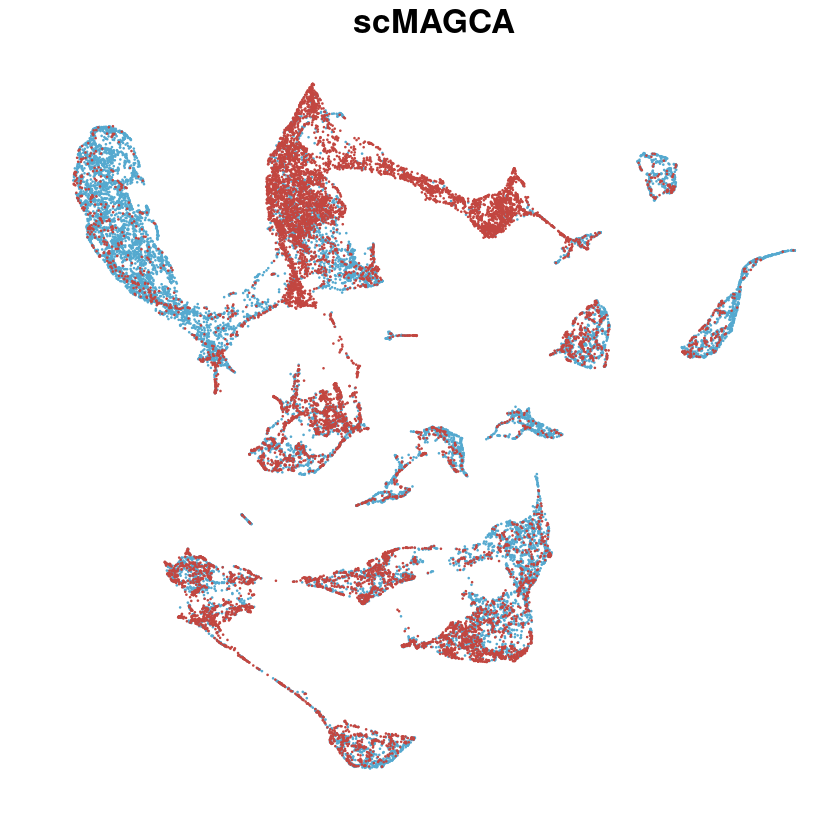

In [28]:
bm_table_num <- data.frame(UMAP1=z.umap$layout[,1], UMAP2=z.umap$layout[,2],Cluster = batch_label)
bm_plot1 <- ggplot(bm_table_num, aes(x = UMAP1, y = UMAP2, color = Cluster)) +
  geom_point(size = 0.1) +
  ggtitle('scMAGCA') +
  theme_bw(base_line_size = 1,base_rect_size = 1)+
  scale_color_manual(values = c("0"="#55A9CF", "1"="#C24640"))+
  labs(x = "", y = "", color = "Label")+  # Set x and y axis labels
  theme(
    plot.title = element_text(size = 20, hjust = 0.5, face = 'bold'),  # Set title to center
    panel.border = element_blank(),
    axis.ticks.length=unit(0, "lines"),  # Remove axis ticks but keep axis labels
    axis.text = element_blank(),
    panel.grid.minor = element_blank(),
    panel.grid.major = element_line(color = NA),
    axis.title.x = element_text(size = 15, hjust = 0.5, vjust = 0.5, color = "black"),
    axis.title.y = element_text(size = 15, hjust = 0.5, vjust = 0.5, color = "black"),
    legend.title = element_blank(),
    legend.text = element_text(size = 15),
    legend.position = "none")+
  guides(color = guide_legend(override.aes = list(size = 5), nrow=2))
bm_plot1